<a href="https://colab.research.google.com/github/mvenouziou/Project-Text-Generation/blob/main/Mo_nonlinear_text_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

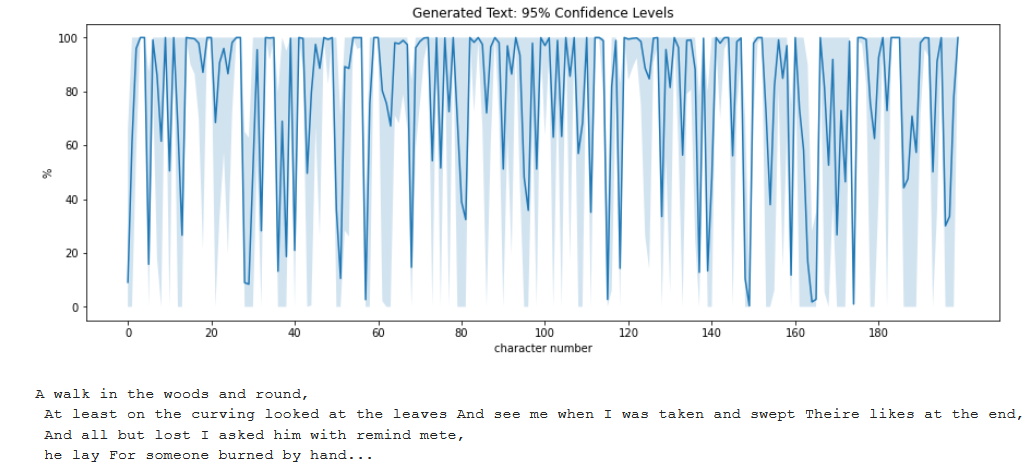

In [60]:
# sample outputs from probabalistc model
from PIL import Image
Image.open('/content/gdrive/MyDrive/Colab_Notebooks/models/text_generation/sample_text_with_conf_plot.PNG')

## Text Generation RNN

This program constructs a character-level sequence model to generate text according to a character distribution learned from the dataset. 

- Try my web app implementation at www.communicatemission.com/ml-projects#text_generation. (Currently, only the standard model is implemented in the app)
- See more at https://github.com/mvenouziou/Project-Text-Generation.

- See credits /attributions below

The code implements three different model architectures: "linear," "nonlinear" and "probablistic."

The linear model uses character-level embeddings to form the model. The nonlinear model adds a parallel word level embedding network, which is merged with the character embedding model. The probablistic model produces distribution objects where each character choice is represented by a Bernouli distribution.



---

**What's New?**
*(These items are original in the sense that I personally have not seen them at the original time of coding. Citations are below for content I have seen elsewhere.)*

Visualization:

- Plotting confidence intervals for character predictions using utilizing Tensorflow Probability distribution layers.

Model Architectures:

- Experiments with: Nonlinear model architecture uses parallel RNN's with both word-level embeddings and character-level embeddings. 

- Experiments with: Tensorflow Probability layers to create a more interpretable probability distribution model. (Character-model only). The standard text generation algorithm outputs logits, which we view as a distribution from which to generate the next character. Here, we formalize this as outputing our model as a TF Probability Distribution, using probablistic weights in the Dense layer (instead of scalars) and trained via maximum likelihood. 

- Proper handling of GRU states for multiple stateful layers

- Easily switch between model architectures through 'Paramaters' class object. Includes file management for organizing each architecture's checkpoints.


Data Processing / Preparation:

*These ideas are not all new, but I have not seen them implemented in text generation systems:*

- Random crops and with random lengths and start locations. 

- Standard (character level) generation separates inputs and targets by one letter (generating one char at a time). This is adjusted for word-embeddings to avoid leaking target data, and multiple characters are generated at a time.

- Load and prepare data from multiple CSV and text files. Each rows from a CSV and each complete TXT file are treated as independent data sources. (CSV data prep accepts titles and content.) 


Generation:

- Add perturbations to learned probabilties in final generation function, to add extra variety to generated text.  (Included in addition to the 'temperature' control described in TF's documentation)

---
**Credits / Citations / Attributions:**

**Linear Model and Shared Code** 

Other than items noted in previous sections, this python code and linear model structure is based heavily on Imperial College London's Coursera course, "Customising your models with Tensorflow 2" *(https://www.coursera.org/learn/customising-models-tensorflow2)* and the Tensorflow RNN text generation documentation *(https://www.tensorflow.org/tutorials/text/text_generation?hl=en).*


**Nonlinear Model:**   

This utilizes pretrained embeddings:
-  Small BERT word embeddings from Tensorflow Hub, (*credited to Iulia Turc, Ming-Wei Chang, Kenton Lee, Kristina Toutanova's paper "Well-Read Students Learn Better: On the Importance of Pre-training Compact Models." *https://tfhub.dev/google/collections/bert/1)*
- ELECTRA-Small++ from Tensorflow Hub, (*credited to Kevin Clark and Minh-Thang Luong and Quoc V. Le and Christopher D. Manning's paper "ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators." *https://hub.tensorflow.google.cn/google/electra_small/2)*

ELECTRA-Small++ has four times as many paramaters as the Small BERT embedding, producing better results, but at large computational cost.

**Web App:** 

The web app is built on the Anvil platform and (at the time of this writing) is hosted on Google Cloud server (CPU).

**Datasets:**

- *'robert_frost_collection.csv'* is a Kaggle dataset available at https://www.kaggle.com/archanghosh/robert-frost-collection. Any other datasets used are public domain works available from Project Gutenberg https://www.gutenberg.org.

---

**About**

Find me online at:
- LinkedIn: https://www.linkedin.com/in/movenouziou/ 
- GitHub: https://github.com/mvenouziou

---

In [33]:
#### PACKAGE IMPORTS ####

# TF Model design
import tensorflow as tf
from tensorflow import keras

# TF text processing (also required for TF HUB word encoders)
!pip install -q tensorflow-text
import tensorflow_text as text  

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import datetime, os

# data management
import numpy as np
import pandas as pd
import string
import random
import re

# file management
import os
import bz2
import _pickle as cPickle

""" ADDITIONAL IMPORTS:
### Imported as needed within 'Paramaters' and GenerationModel classes:
# these are left out to avoid incompatabilities with the cloud server and some 
# of the TF modules

# TF pretrained models (for word encodings)
import tensorflow_hub as hub

# TF probability modules
import tensorflow_probability as tfp  
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd

# Google Drive integration with Google Colab)
from google.colab import drive

# Anvil Web App Server integration
!pip install -q anvil-uplink
import anvil.server
"""

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


" ADDITIONAL IMPORTS:\n### Imported as needed within 'Paramaters' and GenerationModel classes:\n# these are left out to avoid incompatabilities with the cloud server and some \n# of the TF modules\n\n# TF pretrained models (for word encodings)\nimport tensorflow_hub as hub\n\n# TF probability modules\nimport tensorflow_probability as tfp  \nfrom tensorflow_probability import layers as tfpl\nfrom tensorflow_probability import distributions as tfd\n\n# Google Drive integration with Google Colab)\nfrom google.colab import drive\n\n# Anvil Web App Server integration\n!pip install -q anvil-uplink\nimport anvil.server\n"

# Set Paramaters (global)

In [34]:
# paramater customizationss
AUTHOR = 'tests'
DATA_FILES = ['robert_frost_collection.csv']
USE_GDRIVE = True  # required for save / load / checkpoint operations
USE_ANVIL = False
USE_PROBABILITY_LAYERS = True
USE_WORD_PATH = False
USE_ELECTRA = False

### Set Model Paramaters

Define Paramaters class.

*(Controls the model architecture and the file system used for loading data and checkpointing models.)*

In [35]:
class Paramaters:
    def __init__(self,  
                 # integrations
                use_gdrive, use_anvil,
                 
                 # model architecture
                use_probability_layers,  # implements TensorFlow Probability
                use_word_path,  # note: TFP layers not recommended with word-level model 
                use_electra, # use False for BERT embeddings (fewer params, word model only)
                
                # datasets
                author, data_files, 
                datasets_dir='https://raw.githubusercontent.com/mvenouziou/text_generator/main/',
                
                # model hyper params
                num_trailing_words=5, padded_example_length=300, batch_size=32):
        
        # save param choices
        # note: additional attributes are added below
        self._use_gdrive = use_gdrive
        self._use_anvil = use_anvil
        self._author = author       
        self._num_chars_per_step = 1  # characters generated each model call
        self._padded_example_length = padded_example_length
        self._num_trailing_words = num_trailing_words
        self._batch_size = batch_size
        self._use_probability_layers = use_probability_layers
        self._use_word_path = use_word_path
        self._use_electra = use_electra
        self._data_files = list(data_files)
        self._datasets_dir = datasets_dir
        self._embedding_dim = 32*8
        self._char_rnn_units = 32*16
        self._word_rnn_units = 32*6
        self._merge_dim = 32*8

        # Additional Imports
        # # Tensorflow HUB for using pretrained embeddings (word models)
        if self._use_word_path:
            import tensorflow_hub as hub

        # # Tensorflow Probability (probability distribution model architecture)
        if self._use_probability_layers:
            import tensorflow_probability as tfp  
            from tensorflow_probability import layers as tfpl
            from tensorflow_probability import distributions as tfd

        # # Google Drive:
        if self._use_gdrive:
            self._gdrive_dir = '/content/gdrive/'
            from google.colab import drive
            drive.mount(self._gdrive_dir)
        else:
            self._gdrive_dir = ''

        # # Anvil's web app server
        if self._use_anvil:
            !pip install -q anvil-uplink
            import anvil.server
            anvil.server.connect('53NFXI7IX7IE233XQTVJDXUM-PUGRV2WON2LETWBG')
            self.anvil = anvil.server.connect('53NFXI7IX7IE233XQTVJDXUM-PUGRV2WON2LETWBG')

        # Filepath Structure
        # path name conventions due to model structure
        if self._use_probability_layers :
            self._author +=  '/probability/' 
        if self._use_word_path:
            self._author += '_words_model/'
        if self._use_electra:
            self._author += 'electra/'

        # models / checkpoints directories
        # (Google Drive)
        self._filepath = self._gdrive_dir + 'MyDrive/Colab_Notebooks/models/text_generation/' + self._author
        self._checkpoint_dir = self._filepath + '/model_checkpoints/'

        ###self._prediction_model_dir = self._filepath + '/prediction_model/'
        self._training_model_dir = self._filepath + '/training_model/'
        self._processed_data_dir = self._filepath + '/proc_data/'
        self._tensorboard_dir = self._checkpoint_dir  + '/logs/'

        # Create Tokenizer / Set Vocab Size
        # character tokenizer
        def create_character_tokenizer():
        
            char_tokens = string.printable
            filters = '#$%&()*+-/<=>@[]^_`{|}~\t'

            # Initialize standard keras tokenizer
            tokenizer = tf.keras.preprocessing.text.Tokenizer(
                            num_words=None,  
                            filters=filters,
                            lower=False,  # conversion to lowercase letters
                            char_level=True,
                            oov_token=None,  # drop unknown characters
                            )      
            # fit tokenizer
            tokenizer.fit_on_texts(char_tokens)
            
            return tokenizer

        self._character_tokenizer = create_character_tokenizer()
        self._vocab_size = len(self._character_tokenizer.word_index) + 1

    # functions to access attributes
    def tokenizer(self):
        return self._character_tokenizer
    
    def vocab_size(self):
        return self._vocab_size

    def checkpoint_dir(self):
        return self._checkpoint_dir

    def training_model_dir(self):
        return self._training_model_dir

    def use_gdrive(self):
        return self._use_gdrive

    def use_anvil(self):
        return self._use_anvil

    def padded_example_length(self):
        return self._padded_example_length

    def num_chars_per_step(self):
        return self._num_chars_per_step

    def num_trailing_words(self):
        return self._num_trailing_words

    def batch_size(self):
        return self._batch_size
    
    def use_probability_layers(self):
        return self._use_probability_layers

    def use_word_path(self):
        return self._use_word_path

    def use_electra(self):
        return self._use_electra

    def datasets_dir(self):
        return self._datasets_dir

    def embedding_dim(self):
        return self._embedding_dim

    def char_rnn_units(self):
        return self._char_rnn_units

    def word_rnn_units(self):
        return self._word_rnn_units

    def merge_dim(self):
        return self._merge_dim

    def processed_data_dir(self):
        return self._processed_data_dir

    def data_files(self):
        return self.data_files

### Define Model Class

In [36]:
# Model Class
class GenerationModel(tf.keras.Model):

    def __init__(self, paramaters, **kwargs):
        super().__init__(self, **kwargs)
       
        # save attributes
        self._paramaters = paramaters
        self._gru_layer_names_char = ['char_GRU_1', 'char_GRU_2']
        self._gru_layer_names_words = ['word_GRU_1', 'word_GRU_2']

        # imports - Keras
        from keras.layers import Input, Embedding, Dense, GRU, \
                                 Average, AveragePooling1D, \
                                 Dropout, BatchNormalization, Lambda
        
        # imports - Tensorflow Probability
        if self._paramaters.use_probability_layers():
            import tensorflow_probability as tfp  
            from tensorflow_probability import layers as tfpl
            from tensorflow_probability import distributions as tfd

        # imports - Tensorflow HUB (pretrained embeddings)
        if self._paramaters.use_word_path():
            import tensorflow_hub as hub

        # Set checkpoint manager
        self.checkpoint, self.checkpoint_manager = self.create_checkpoint_manager()

        # params for model architecture 
        use_word_path = paramaters.use_word_path()
        use_probability_layers = paramaters.use_probability_layers()
        vocab_size = paramaters.vocab_size()
        embedding_dim = paramaters.embedding_dim()
        char_rnn_units = paramaters.char_rnn_units()
        word_rnn_units = paramaters.word_rnn_units()
        merge_dim = paramaters.merge_dim()
        char_input_length = paramaters.padded_example_length()
        
        # initialize placeholder TensorArrays (when not stateful)
        # ## for stateful path
        self.states_char_array = self.initialize_tensorarray(
                                        size=len(self._gru_layer_names_char),
                                        init_with_zero_units=char_rnn_units)
        self.states_words_array = self.initialize_tensorarray(
                                        size=len(self._gru_layer_names_words),
                                        init_with_zero_units=word_rnn_units)
        # ## placeholder value for non-stateful path
        self.init_states_zeros_placeholder = self.create_zeros_placeholder()

        # Model Layers
        # ## Encoders
        if use_word_path:
            self.bert_tokenizer, self.bert_packer, self.bert_encoder = \
                        self.get_word_encoder()
                        
        self.char_embedding = Embedding(input_dim=vocab_size, 
                                        output_dim=embedding_dim, 
                                        mask_zero=True,
                                        name='char_embedding',
                                        input_length=char_input_length)
        
        # ## Character Path       
        self.char_GRU_1 = GRU(units=char_rnn_units, return_state=True, 
                              return_sequences=True, name='char_GRU_1')
        self.char_Batch_Norm_1 = BatchNormalization(name='char_Batch_Norm_1')
        self.char_GRU_2 = GRU(units=char_rnn_units, return_state=True, 
                              return_sequences=True, name='char_GRU_2')
        self.char_Batch_Norm_2 = BatchNormalization(name='char_Batch_Norm_2')

        # ## Word Path
        if use_word_path:
            self.word_GRU_1 = GRU(units=word_rnn_units, return_state=True, 
                                  return_sequences=True, name='word_GRU_1',)
            self.word_Batch_Norm_1 = BatchNormalization(name='word_Batch_Norm_1')
            self.word_GRU_2 = GRU(units=word_rnn_units, return_state=True, 
                                  return_sequences=False, name='word_GRU_2',)
            self.word_Batch_Norm_2 = BatchNormalization(name='word_Batch_Norm_2')

        # ## Merge Char and Words paths
        if use_word_path:
            self.char_Dense_merge = Dense(units=merge_dim, activation=None, 
                                          name='char_Dense_merge')
            self.word_Dense_merge = Dense(units=merge_dim, activation=None, 
                                          name='word_Dense_merge')
            self.word_reshape = Lambda(lambda x: tf.expand_dims(x, axis=1), 
                                       name='word_reshape')
            self.merged_layers = Lambda(lambda x: tf.concat([x[0][:, 1:, :], # drop first value to preserve shape after concat
                                        x[1]], axis=1), name='merged_layers')     
        else:
            self.rename = Lambda(lambda x: x, name='rename_variable')       
        self.Batch_Norm_output = BatchNormalization(name='Batch_Norm_output')
        
        # ## Output logits
        if use_probability_layers:

            # bayesian components
            self.dense_tfp = tfpl.DenseLocalReparameterization(activation=None,
                    units=tfpl.IndependentBernoulli.params_size(vocab_size))                     
            self.decoding = tfpl.IndependentBernoulli(event_shape=[vocab_size],
                convert_to_tensor_fn=tfd.Bernoulli.logits, name='Decoding')

        else:
            self.dense_outputs = Dense(units=vocab_size, activation=None, 
                                       name='Decoding')      
                
    def call(self, inputs, initial_states=None, stateful=False, **kwargs):
       
        # set model params
        use_word_path = self._paramaters.use_word_path()
        use_probability_layers = self._paramaters.use_probability_layers()
        indx_state = None
        
        if stateful:

            # initialize states containers (TensorArray)
            states_char = self.states_char_array

            if use_word_path:
                states_words = self.states_words_array

            # unpack states info if it was passed in
            if initial_states is not None:

                # characters array
                states_list_char = tf.unstack(initial_states[0])
                for indx in range(len(self._gru_layer_names_char)):
                    states_char = states_char.write(indx, states_list_char[indx])     
                
                # words array
                if use_word_path:
                    states_list_words = tf.unstack(initial_states[1])
                    for indx in range(len(self._gru_layer_names_char)):         
                        states_words = states_words.write(indx, states_list_words[indx])                            
        
        # Begin Model Path
        input_1 = inputs[0]
        input_2 = inputs[1]

        # ## Character Path Layers
        x1 = self.char_embedding(input_1)
        
        # Char GRU 1
        if stateful:
            indx = self._gru_layer_names_char.index('char_GRU_1')
            if initial_states is not None:
                indx_state = states_char.read(indx)

            x1, new_indx_state = self.char_GRU_1(x1, initial_state=indx_state)
            states_char = states_char.write(indx, new_indx_state)
        
        else:
            x1, _ = self.char_GRU_1(x1, initial_state=None)

        x1 = self.char_Batch_Norm_1(x1)

        # Char GRU 2
        if stateful:
            indx = self._gru_layer_names_char.index('char_GRU_2')
            if initial_states is not None:
                indx_state = states_char.read(indx)
            x1, new_indx_state = self.char_GRU_2(x1, initial_state=indx_state)
            states_char = states_char.write(indx, new_indx_state)
        else:
            x1, _ = self.char_GRU_2(x1, initial_state=None)
        
        x1 = self.char_Batch_Norm_2(x1)

        # Word Encoding Path Layers
        if use_word_path:
            # encoding
            x2 = self.bert_tokenizer(input_2)  # tokenize
            x2 = self.bert_packer([x2])  # pack inputs for encoder
            x2 = self.bert_encoder(x2)['sequence_output'] # encoding
            
            # Word GRU 1
            if stateful:
                indx = self.gru_layer_names_words.index('word_GRU_1')
                if initial_states is not None:
                    indx_state = states_words.read(indx)
                x2, new_indx_state = self.word_GRU_1(x2, initial_state=indx_state)
                states_words = states_words.write(indx, new_indx_state)
            else:
                x2, _ = self.word_GRU_1(x2, initial_state=None)
            x2 = self.word_Batch_Norm_1(x2)

            # Word GRU 2
            if stateful:
                indx = self.gru_layer_names_words.index('word_GRU_2')
                if initial_states is not None:
                    indx_state = states_words.read(indx)
                x2, new_indx_state = self.word_GRU_2(x2, initial_state=indx_state)
                states_words = states_words.write(indx, new_indx_state)
            else:
                x2, _ = self.word_GRU_2(x2, initial_state=None)
            x2 = self.word_Batch_Norm_2(x2)

        # Merge Layers
        if use_word_path:
            x1 = self.char_Dense_merge(x1)
            x2 = self.word_Dense_merge(x2)
            x2 = self.word_reshape(x2)
            x = self.merged_layers((x1, x2))
            
        else:  # update variable id to match next step
            x = self.rename(x1)
                
        x = self.Batch_Norm_output(x)

        # Character prediction (logits)
        if use_probability_layers:  # weights are prob dstributions
            x = self.dense_tfp(x)
            y_pred = self.decoding(x)     

        else:
            y_pred = self.dense_outputs(x)

        # handle statefulness
        if stateful:
            new_char_states = states_char.stack()
            #states_char.close()

            if use_word_path:
                new_word_states = states_words.stack()
                #states_words.close()
            else:
                new_word_states = self.init_states_zeros_placeholder[1]
            new_states = tf.tuple([new_char_states, new_word_states])

        else:
            new_states = self.init_states_zeros_placeholder

        return y_pred, new_states


    # Checkpoint Manager
    def create_checkpoint_manager(self):
        """ manages automatic saving during model training """

        checkpoint = tf.train.Checkpoint(model=self)
        checkpoint_manager = tf.train.CheckpointManager(
                                checkpoint=checkpoint, 
                                directory=self._paramaters.checkpoint_dir(), 
                                max_to_keep=4, 
                                keep_checkpoint_every_n_hours=None,
                                checkpoint_name='ckpt', 
                                step_counter=None, 
                                checkpoint_interval=None,
                                init_fn=None)

        return checkpoint, checkpoint_manager
    

    def get_word_encoder(self):
        """ loads pretrained word embedding models """

        import tensorflow_hub as hub

        # Word Embeddings
        # Selects file locations for BERT or ELECTRA pretrained encoders
        if self._paramaters.use_electra():
            encoder_url = 'https://tfhub.dev/google/electra_small/2'
        else:
            encoder_url = 'https://tfhub.dev/tensorflow/' \
                                + 'small_bert/bert_en_uncased_L-2_H-128_A-2/1'
        preprocessor_url = 'https://tfhub.dev/tensorflow/' \
                            + 'bert_en_uncased_preprocess/3'
                
        # Get Encoder / Preprocessing layers
        preprocessor = hub.load(preprocessor_url)

        bert_tokenizer = hub.KerasLayer(preprocessor.tokenize, name='bert_tokenizer')
        
        bert_packer = hub.KerasLayer(
                        preprocessor.bert_pack_inputs,
                        name='bert_input_packer')

        word_encoder = hub.KerasLayer(encoder_url, trainable=False, 
                                    name='Word_encoder')

        
        return bert_tokenizer, bert_packer, word_encoder

    
    # Tensor Arrays
    def initialize_tensorarray(self, size, init_with_zero_units=None):
        """ note: We use Tensor Arrays to hold GRU state values """
        
        array = tf.TensorArray(tf.float32, size=size, clear_after_read=True)    
        array.trainable=False      

        if init_with_zero_units is not None:        
            zeros = tf.zeros((1, init_with_zero_units))           
            for indx in range(size):         
                array = array.write(indx, zeros)

        return array 

    def create_zeros_placeholder(self):
        """ Creates placeholders for when model is set to stateful=False.
        Output is same shape as saved model states """

        char_rnn_units = self._paramaters.char_rnn_units()
        word_rnn_units = self._paramaters.word_rnn_units()

        states_char_array_zeros = self.initialize_tensorarray(
                                            size=len(self._gru_layer_names_char),
                                            init_with_zero_units=char_rnn_units)
        states_words_array_zeros = self.initialize_tensorarray(
                                            size=len(self._gru_layer_names_words),
                                            init_with_zero_units=word_rnn_units)

        # ## convert to init state placeholder
        char_states = states_char_array_zeros.stack()
        word_states = states_words_array_zeros.stack()
        char_states.trainable = False       
        word_states.trainable = False  

        # ## close out zeros TensorArrays (for non-stateful path)
        states_char_array_zeros.close()
        states_words_array_zeros.close()

        return tf.tuple([char_states, word_states])

    def paramaters(self):
        return self._paramaters

## Input Pipeline

Load and Clean Datasets

In [37]:
# Function: loader for .csv files
def prepare_csv(filename, paramaters, content_columns=['Title', 'Content']):
    
    """ Process CSV files. Text must be in column named 'Content', 
    (with optional 'Title' column allowed for titles)."""

    # load data into DataFrame
    dataframe = pd.read_csv(paramaters.datasets_dir() + filename).dropna()
    
    # extract titles and content
    # note: column headings must match those below
    # This step is specific to the Robert Frost set
    if 'Name ' in dataframe.columns:  
        dataframe.rename(columns={'Name ':'Title'})
    
    # prepare titles
    if 'Title' in dataframe.columns:  # add ':\n'
        dataframe['Title'] = dataframe['Title'].apply(lambda x: x + ':\n')
    else:  # no titles found
        content_columns = ['Content']

    # prepare content
    #dataframe['Content'] = dataframe['Content'].apply(lambda x: x + '\n')
    #dataframe = dataframe[content_columns]

    # shuffle entries (rows)
    dataframe = dataframe.sample(frac=1)
    
    # merge desired text columns
    dataframe['merge'] = dataframe[content_columns[0]]
    for i in range(1, len(content_columns)):
        dataframe['merge'] = dataframe['merge'] + dataframe[content_columns[i]]

    # convert to list of strings
    data_list = dataframe['merge'].tolist()
    
    return data_list   


# Function: Load and standardize data files
def load_parse(data_list):  
    """
    Placeholder function for any other data prep steps
    """
    return clean_list

In [38]:
def input_pipeline(paramaters, fresh_process=False):

    # unpack param
    saved_proc_dir = paramaters.processed_data_dir()
    filepath = paramaters.datasets_dir()

    # load previously processed data if possible
    # (pbz2 compressed file format)
    try:    
        assert(fresh_process is False)  # otherwise create dataset from files

        with bz2.open(saved_proc_dir + 'datafiles.pbz2', 'rb') as file:
            data_dict = cPickle.load(file)

        clean_list = data_dict['clean_list']
        print('loaded saved pre-processed data')

    # process data if no saved data found
    except:       

        # load raw data files from disk
        data_list = []
        for filename in paramaters.data_files():
            print(filename)
            print(filepath + '/' + filename)

            # select loader (csv or txt)
            _, file_extension = os.path.splitext(filename)     

            if file_extension == '.csv':   
                data = prepare_csv(filename, paramaters=paramaters,
                                   content_columns=['Name', 'Content'])
            
            else: # '.txt':
                with open(filepath + '/' + filename, 'r', encoding='utf-8') as file:
                    data = file.readlines()

            # update list of extracted texts
            data_list += data

        print('PROGRESS: data_list created')
        
        # clean the data
        clean_list = load_parse(data_list)
        print('PROGRESS: clean_list created')
        
        # save data to disk (pbz2 compressed file format)
        with bz2.BZ2File(saved_proc_dir + 'datafiles.pbz2', 'wb') as sfile:
            cPickle.dump({'clean_list': clean_list}, sfile)

    return clean_list

Dynamic Dataset Creation

In [39]:
def random_text_blocks(full_examples, num_batches, paramaters,
                       for_training=True):

    """ 
    When 'for_training' is True, this creates random crops 
    of examples and creates input / target pairs for model training. 
    
    Otherwise this prepares a single text for input into model
    """

    # skip on inference
    if not for_training:
        char_blocks = full_examples
        return char_blocks

    num_chars_per_step = paramaters.num_chars_per_step()
    max_length = paramaters.padded_example_length() + num_chars_per_step
    num_examples = len(full_examples)
    num_sets = int(num_batches * paramaters.batch_size())
    num_words = paramaters.num_trailing_words()
    use_word_path = paramaters.use_word_path()


    # count total characters
    example_starts = [0]
    for i in range(num_examples):
        example_length = len(full_examples[i])
        example_starts.append(example_starts[i] + example_length + 1)

    total_chars = example_starts[-1]
    example_starts = example_starts[:-1]

    # create input / target blocks
    char_blocks = []
    word_blocks = []
    target_blocks = []
    
    if use_word_path is False:
        min_example_length = 10 + num_chars_per_step
    else:
        # note: word path leaks a lot of info on its overlap
        # with chars input / target. Need to keep num words small 
        # compared to example length to compensate
        min_example_length = 10*num_words + num_chars_per_step
    
    
    completed = False
    while not completed:

        # choose random starting locations
        starting_points = tf.experimental.numpy.random.randint(
                                low=0, high=total_chars-min_example_length, 
                                size=num_sets)

        for start in starting_points:

            # find containing example
            temp = [i for i in range(num_examples) 
                    if start >= example_starts[i]]
           
            example_num = temp[-1]
            this_example = full_examples[example_num]
            this_ex_start = example_starts[example_num]

            if example_num < num_examples - 1:
                next_ex_start = example_starts[example_num + 1]
            else:
                next_ex_start = total_chars

            # cap length to stay within containing example
            # and is not cropped when converted to padded array
            length = min(next_ex_start - start, max_length)
            
            # enforce min character length
            if length < min_example_length:
                continue  # skip to next sample
            
            # crop sample
            cropped_text = this_example[(start - this_ex_start): 
                                        length + (start - this_ex_start)]

            # require first 'word' to be complete
            if start != this_ex_start:
                skip_to_next = False
                while cropped_text[0] != ' ':
                    cropped_text = cropped_text[1:]
                    
                    if len(cropped_text)==0:  
                        # ran out fo characters, skip example
                        skip_to_next = True
                        break
                if skip_to_next:
                    continue
                cropped_text = cropped_text[1:]         

            # update input / target blocs
            char_blocks.append(cropped_text)
             
            if len(char_blocks) >= num_sets:
                completed = True
                break

    return char_blocks

In [40]:
# Character-Level Encoder

def make_padded_array(text_blocks, paramaters, padding, for_training):
    # Tokenizes and applies padding for uniform length

    # load tokenizer if one is not supplied
    tokenizer = paramaters.tokenizer()

    # tokenize
    token_blocks = tokenizer.texts_to_sequences(text_blocks)

    # zero padding
    # (this will later be split into input / target)
    if for_training:
        maxlen = paramaters.padded_example_length() + paramaters.num_chars_per_step()

        padded_blocks = tf.keras.preprocessing.sequence.pad_sequences(
                            sequences=token_blocks,  # dataset
                            maxlen=maxlen, 
                            dtype='int32', 
                            padding=padding,
                            truncating=padding,
                            value=0.0
                            )
    else: 
        padded_blocks = np.array(token_blocks)
    
    return padded_blocks

In [41]:
def create_random_dataset(clean_list, num_batches, paramaters,
                          for_training=False):

    # get params
    num_chars_per_step = paramaters.num_chars_per_step()
    num_words = paramaters.num_trailing_words()

    # select data samples by applying random crops
    char_blocks = random_text_blocks(clean_list, num_batches, 
                                     paramaters, for_training) 
    
    # convert characters to array
    # and split into inputs / targets
    char_array = make_padded_array(char_blocks, paramaters, padding='pre', 
                                   for_training=for_training)

    if for_training:
        char_input = char_array[:, : -num_chars_per_step]
        target = char_array[:, num_chars_per_step: ]
    else:
        char_input = char_array
        target = char_input
    
    # create words inputs
    if paramaters.use_word_path():
        def split_words(text):
            text = text[: -num_chars_per_step]
            words = text.split()[:-1]  # drop (possibly partial) last word
            words = words[: num_words]
            return ' '.join(words)

        word_input = np.array([split_words(text) for text in char_blocks])
    else:
        word_input = tf.constant(' ', shape=char_array.shape[0])

    # update to TF dtypes
    char_input = tf.constant(char_input, dtype=tf.int32, name='char_input')
    target = tf.constant(target, dtype=tf.int32, name='target')
    word_input = tf.constant(word_input, dtype=tf.string, name='word_input')

    # batch and shuffle for training
    if for_training:    
        ds = tf.data.Dataset.from_tensor_slices((
                    (char_input, word_input), target))
        ds = ds.batch(paramaters.batch_size())\
        .shuffle(5000)\
        .prefetch(tf.data.experimental.AUTOTUNE)\
    
    else:
        ds = (char_input, word_input)
    
    return ds


# Training Loop

Loss Functions

In [42]:
#VOCAB_SIZE = len(create_character_tokenizer().word_index) + 1

def neg_log_likely_logits(y_true, y_pred, depth):
    """ loss function for probabalistic model """

    # encode labels as one-hot vectors
    y_true_hot = tf.one_hot(y_true, depth=depth, axis=-1)

    # compute negative log likelihood
    nll = -y_pred.log_prob(y_true_hot)
    return tf.reduce_mean(nll)

In [43]:
def loss(model, y_pred, target):

    # compute loss
    if model.paramaters().use_probability_layers():
        depth = model.paramaters().vocab_size()
        loss = neg_log_likely_logits(target, y_pred, depth)

    else:
        loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)(target, y_pred)

    return loss

Gradient Step

In [44]:
@tf.function(experimental_relax_shapes=True)
def grad(model, inputs, states, target, stateful):

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)

        # compute predictions
        y_pred, states = model(inputs, initial_states=states, stateful=stateful)
        
        # compute loss
        loss_value = loss(model, y_pred, target)
    
    # get gradients
    grads = tape.gradient(loss_value, model.trainable_variables)
    
    return loss_value, grads, states

Custom Training Loop

In [45]:
# Function: Train model
def train_model(model, cleaned_data_list, num_epochs, 
                batches_per_epoch, learning_rate, 
                optimizer=keras.optimizers.Adam):

    # get params
    paramaters = model.paramaters()
    stateful = False
    
    # get optimizer
    if learning_rate is not None:
        optimizer=optimizer(learning_rate=learning_rate)
    else:
        optimizer=optimizer()
    
    # set checkpoint manager
    if model.checkpoint is None or model.checkpoint_manager is None:
        create_checkpoint_manager(model=model)

    # initialize containers for metrics
    train_loss_results = []
    
    """
    # set callbacks
    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                log_dir=paramaters._tensorboard_dir, 
                                histogram_freq=1,
                                )
    """
    
    # begin training loop
    # prepare datasets

    for epoch in range(num_epochs):

        tf.print(f'Epoch: {epoch}')

        # initialize epoch metrics
        epoch_loss_avg = tf.keras.metrics.Mean()

        # create dataset from randomized text crops
        num_batches = max(batches_per_epoch, 1)
        dataset = create_random_dataset(cleaned_data_list, 
                                        num_batches, 
                                        paramaters,
                                        for_training=True)
        
        # train model
        iteration = 0
        for (inputs, targets) in dataset:

            # get grads and loss
            if stateful is False:  # ensure no states passed in to model
                states = None
            loss_value, grads, states = \
                grad(model, inputs, states, targets, stateful=stateful)
            
            # update weights
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # update metrics
            epoch_loss_avg(loss_value)
            
            # report results
            if iteration % 5 == 0:
                ave_loss = epoch_loss_avg.result().numpy()
                tf.print(f'  - loss: {np.format_float_positional(ave_loss, 4)}')
            
            iteration += 1

        # End of Epoch
        # save checkpoint
        model.checkpoint_manager.save()

        # record epoch metrics
        ave_loss = epoch_loss_avg.result().numpy()
        train_loss_results.append(ave_loss)
        mean_loss = np.mean(train_loss_results)
        
        # report epoch summary
        tf.print(f'epoch ave loss: {np.format_float_positional(ave_loss, 4)}')
        tf.print(f'overall ave loss: {np.format_float_positional(mean_loss, 4)}')

        # show sample result
        if epoch % 3 == 0:
            num_generation_steps = 20
            sample_input = 'The road less travelled is'
            
            tf.print('\nSample input:', sample_input)
            tf.print('Output:', end='')
            generate_text(input_text=sample_input, 
                          prediction_model=model,
                          precision_reduction=0,
                          temperature=1,
                          num_generation_steps=num_generation_steps,
                          print_result=True)

    # end of training    
    # save checkpoint
    model.checkpoint_manager.save()

    # consolidate saved metrics
    history = [train_loss_results]

    return model, history

Saving Models

In [46]:
# Store trained model separate from checkpoints
def save_model(model, paramaters):

    model_dir = paramaters.training_model_dir()
    
    # save model
    tf.saved_model.save(model, model_dir)

    return None

### Text Generation Functions


In [47]:
def convert_to_input(generated_text, paramaters):    

    if generated_text == '':
        generated_text = ' '
        
    generated_text = [generated_text]

    input = create_random_dataset(generated_text, 
                                     num_batches=1, 
                                     paramaters=paramaters,
                                     for_training=False)
    return input

In [48]:
def generator(input_text, prediction_model, precision_reduction, temperature,
              num_steps, print_result, collect_stats=False):

    # get tokenizer and params
    paramaters = prediction_model.paramaters()
    tokenizer = paramaters.tokenizer()
    num_characters_per_step = paramaters.num_chars_per_step()
    
    # enforce dtypes
    temperature = tf.constant(temperature, tf.float32)
    precision_reduction = tf.constant(precision_reduction, tf.float32)
    
    # initialize generated text
    generated_text = input_text
    
    # set initial GRU state values
    initial_states = None

    # initialize containers for saving probability statistics
    #(note: feature only implemented for num_characters_per_step=1)
    st_devs = np.zeros(num_steps)
    means = np.zeros(num_steps)

    # text generation loop
    for i in range(num_steps):
        
        # tf.print('input_text:', input_text)
        # prepare input for model
        input = convert_to_input(input_text, paramaters)
    
        # run model and get logits of last character prediction
        logits, initial_states = prediction_model(input, 
                                                  initial_states, 
                                                  stateful=True)
        
        # save mean and standard deviations
        if collect_stats:       
            std = logits.stddev()[0, -num_characters_per_step, :]
            mu = logits.mean()[0, -num_characters_per_step, :]

        # extract newly generated character logits
        logits = logits[0, -num_characters_per_step:, :]

        # 'temperature' control to distort probabilities
        if temperature != 1.:  
            logits = logits / temperature
        
        # 'precision reduction' (random perturbations to probs)
        if precision_reduction != 0.:            
            fuzz_factor = tf.random.normal(shape=logits.shape, 
                                           mean=1, 
                                           stddev=.2)
            logits = logits * (1 + precision_reduction * fuzz_factor)
        
        # Choose a token using the logits probability distribution
        new_tokens = tf.random.categorical(logits=logits, num_samples=1) 
        
        # get stats for generated character
        if collect_stats:
            print
            st_devs[i] = std.numpy()[new_tokens]
            means[i] = mu.numpy()[new_tokens]

        # get newly predicted characters
        # (becomes input for next iteration)
        new_tokens = new_tokens.numpy().tolist()
        input_text = tokenizer.sequences_to_texts(new_tokens)
        #print('input_text:', input_text)

        # updated generated text
        input_text = ''.join(input_text)
        generated_text = generated_text + input_text
        
    if print_result:
        tf.print(generated_text)

    return generated_text, means, st_devs

Plotting Confidence in our Generated Text

In [49]:
def show_confidence(result_text, result_means, result_stdevs):

    num_steps = result_means.shape[0]
    min_cuttof = np.zeros(num_steps)
    max_cuttof = np.ones(num_steps)

    mins = np.max(np.stack([min_cuttof, result_means - 1.96*result_stdevs], 
                           axis=0), axis=0)
    maxes = np.min(np.stack([max_cuttof, result_means + 1.96*result_stdevs], 
                            axis=0), axis=0)

    df = pd.DataFrame.from_dict({'Lower Bound': 100*mins, 
                                 'Upper Bound': 100*maxes, 
                                 'means': 100*result_means})
    
    ax = df['means'].plot(title='Generated Text: 95% Confidence Levels', xticks=range(0, num_steps, 20), 
            xlabel='character number', ylabel='%', figsize=(15, 5))
    
    ax.fill_between(df.index, df['Lower Bound'], df['Upper Bound'], alpha=0.2)
    plt.show()
       
    return None


Final generation function for end user

In [50]:
def generate_text(input_text, 
                  prediction_model,
                  print_result,
                  precision_reduction=0.,
                  temperature=1,
                  num_generation_steps=150,    # sets length of generated text
                  show_confidence_plot=False):


    # format user input
    if input_text == '':
        input_text = ' '
    starting_text = input_text[0].upper()
    
    if len(input_text) >= 2:
        starting_text += input_text[1:]
    paramaters = prediction_model.paramaters()

    # get generated text
    prediction, result_means, result_stdevs = \
                  generator(input_text=starting_text, 
                            prediction_model=prediction_model, 
                            precision_reduction=precision_reduction, 
                            temperature=temperature,
                            num_steps=num_generation_steps, 
                            print_result=False,
                            collect_stats=show_confidence_plot)                                   
   
    # define formatting rules
    split_on = ['?', '.', ',', ';', '!', ':']
    splits = '([' + ''.join(split_on) + '])'
    split_lines_prediction = re.split(splits, prediction)

    # format output
    output = ''
    for line in split_lines_prediction:

        # capitalize first word of each line   
        if len(line) >= 1:
            line_update = line[0].upper()  

            # add capitalized letter to remainder of line
            if len(line) >= 2:
                line_update += line[1:]
        else:
            line_update = ''
                
        # update output text
        if (len(line_update) >= 1 and line_update[-1] in split_on) \
          or (len(line_update) >= 2 and line_update[-2:] == '\n'):
                output = ''.join([output, line_update])
        else:
            output = '\n'.join([output, line_update])

    if show_confidence_plot:
        if print_result:
            print('Generated Text:\n', output + '... \n')
        show_confidence(prediction, result_means, result_stdevs)

    elif print_result:
        print(output + '... ')
    
    return output + '... '

# Implementation

Set paramaters

In [51]:
# create paramaters object
paramaters = Paramaters(use_gdrive=USE_GDRIVE, use_anvil=USE_ANVIL, 
                        author=AUTHOR, data_files=DATA_FILES,
                        use_probability_layers=USE_PROBABILITY_LAYERS,
                        use_word_path=USE_WORD_PATH, use_electra=USE_ELECTRA)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Load and Process Data

In [52]:
require_fresh_process = False

try:
    # check if prepared datasets already in memory
    assert(require_fresh_process is False)
    assert(len(X_data_list) > 0)
    print('dataset already loaded')

except:
    print('Preparing dataset')
    cleaned_data_list = input_pipeline(paramaters=paramaters, 
                                       fresh_process=require_fresh_process)

Preparing dataset
loaded saved pre-processed data


Initialize Training Model

In [53]:
model = GenerationModel(paramaters=paramaters)

# build model by running an element through it
input = convert_to_input(' ', paramaters=model.paramaters())
temp = model(input, initial_states=None, stateful=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Load Latest Training Checkpoint

In [54]:
load_checkpoint=True
try:
    assert(load_checkpoint is True)

    # load checkpoint
    model.checkpoint_manager.restore_or_initialize()
    print('loaded checkpoint')

except: 
    print('No checkpoint loaded')

loaded checkpoint


Train Model

*Training loop dynamically generates training data from the text using random crops of random lengths to improve predictions and reduce overfitting.  Sample outputs are shown periodically to observe model improvements.*

In [ ]:
train_model_now = True

learning_rate = .0001  # note: TFP variational layers benefit from using very small learning rates
num_epochs = 100
batches_per_epoch = 50

# train model
if train_model_now:
    model, history = train_model(model, cleaned_data_list,
                                 num_epochs=num_epochs, 
                                 learning_rate=learning_rate,
                                 batches_per_epoch=batches_per_epoch,
                                 optimizer=keras.optimizers.RMSprop,
                                 )  

Save Models

In [ ]:
save_model_now = True

if save_model_now:
    save_model(model, paramaters=model.paramaters())

## Test Output: Generate Text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Generated Text:
 
A walk in the woods and round,
 At least on the curving looked at the leaves And see me when I was taken and swept Theire likes at the end,
 And all but lost I asked him with remind mete,
 he lay For someone burned by hand... 



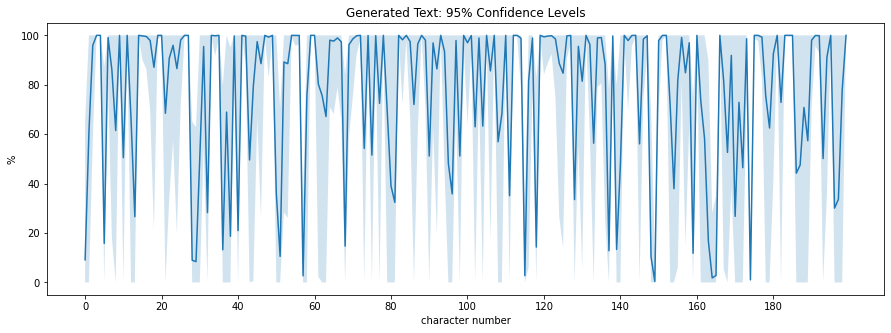


A walk in the woods and round,
 At least on the curving looked at the leaves And see me when I was taken and swept Theire likes at the end,
 And all but lost I asked him with remind mete,
 he lay For someone burned by hand... 


In [56]:
starting_text = 'A walk in the woods'
precision_reduction = .05 
temperature=.7,

# NOTE: if using word path, recommeded using  >= paramaters.num_trailing_words() 
# words in starting text

gen = generate_text(starting_text, 
                    prediction_model=model,
                    precision_reduction=precision_reduction,
                    temperature=temperature,
                    print_result=True,
                    num_generation_steps=200,
                    show_confidence_plot=True)

print(gen)

## Web App

Anvil Web App Server Integration

In [ ]:
if model.paramaters().use_anvil():

    # enable connection
    !pip install -q anvil-uplink
    import anvil.server
    anvil.server.connect(self.anvil_code)


    @anvil.server.callable
    def anvil_callable(starting_text, 
                       precision_reduction=0,
                       temperature=1,
                       paramaters=PARAMATERS, ####### not used -- remove
                       prediction_tokenizer=PARAMATERS._character_tokenizer, ####### not used -- remove
                       prediction_model=model,
                       print_result=True,
                       author='assorted',
                       num_generation_steps=150):
        
        paramaters = prediction_model.paramaters()

        if paramaters._use_word_path:
            num_generation_steps = max(1, num_generation_steps // len(starting_text))

        return generate_text(starting_text=starting_text, 
                             precision_reduction=precision_reduction,
                             temperature=temperature,
                             prediction_model=prediction_model,
                             print_result=print_result,
                             num_generation_steps=num_generation_steps)

    # start persistent connection to server
    anvil.server.wait_forever()